# Braiding Toric Code Excitations

The toric code model is a treasure trove of interesting physics and mathematics. It is the quintessential example of a <b>surface code</b> and describes a key category of error correction models. But why is the model so useful for error correction? 

A deeper answer to that question touches on some amazingly rich areas of mathematics and condensed matter physics. In order to protect from local fluctuations, we turn to a dependence on non-local properties. If we want to study non-local properties, we need to start using topology, the mathematical study of properties that are invariant under continuous deformation. For example, a coffee cup is equivalent to a donut, or a cow really is spherical!

<a title="Keenan Crane; GIF by username:Nepluno, CC BY-SA 4.0 &lt;https://creativecommons.org/licenses/by-sa/4.0&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Spot_the_cow.gif"><img width=200em alt="Spot the cow" src="https://upload.wikimedia.org/wikipedia/commons/2/24/Spot_the_cow.gif"></a>
Keenan Crane; GIF by username:Nepluno, CC BY-SA 4.0 <https://creativecommons.org/licenses/by-sa/4.0>, via Wikimedia Commons

At least a cow without a digestive track.

When we zoom in really close, both a sphere and a torus look the same. Only when you zoom out and consider the whole object can you see the differences.

One subset of topology is called [Homotopy](https://en.wikipedia.org/wiki/Homotopy). Two paths are <b>homotopy equivalent</b> if they can be continuously deformed into each other. For the next picture, assume the red "X" is some kind of defect in space, like a tear in a sheet or some kind of object.  The two blue paths are equivalent to each other because you can smoothly move one into the other.  You cannot move the blue path into the green path without going through the defect, so they are <i>not</i> equivalent to each other.

<img src="./homotopy.png" width=200em/>

What does all this mathematics have to do with actual physics? The toric code is considered a <b>topological state of matter</b>.  These states of matter often share properties like:

* long range entanglement entropy
* ground state degeneracy
* a global influence of edges
* non-trivial excitations

An excitation or excited state is an eigenstate that is not the ground state.

In this demo, we will be looking at the degenerate ground state and the excitations of the toric code model. The toric code was initialized proposed in "Fault-tolerant quantum computation by anyons" by Kitaev, and this demo was inspired by "Realizing topologically ordered states on a quantum processor" by K. J. Satzinger et al. For further reading, I recommend "Quantum Spin Liquids" by Lucile Savary and Leon Balents. (add links and proper citations and stuff)

To describe these excitations, I will introduce a second term: <b>quasiparticle</b>. Quasiparticles allow physicists to describe complex systems as interacting particles in a vacuum.  Common examples of quasiparticles include electrons and holes in semiconductors, phonons, and magnons.

Imagine trying to describe the traffic on a road. We could either:

* explicitly enumerate the location of each vehicle
* describe the locations and severities of traffic jam

The first option provides the complete information about the system but is much more difficult to work with. For most purposes, we can just work with information about how the traffic deviates from a baseline. In semiconductors, we don't write out the wavefunction for every single electron. We instead use electrons and holes. Neither quasiparticle electrons or holes are fundamental particles like an electron or positron in a vacuum. Instead, they are useful descriptions of how the wavefunction differs from its ground state.

While the electrons and holes of a metal behave just like electrons and positrons in a vacuum, some condensed matter systems contain quasiparticles that cannot or do not exist as fundamental particles.

When one indistinguishable fermion of spin 1/2 orbits another fermion of the same type, the combined wavefunction picks up a factor of negative one. When fermions of different types orbit each other, the state is unchanged. For example, if an electron goes around a proton and comes back to the same spot, the wavefunction is unchanged.  If a boson orbits around a different type of boson, again the wavefunction is unchanged.

What if a particle went around a different type of particle and everything picked up a phase? Would it be a boson or a fermion?

It would be something else entirely: an <b>anyon</b>. An anyon is anything that doesn't cleanly fall into the boson+fermion categorization of particles.  

While the toric code itself is just an extremely useful mathematical model, anyons actually exist in real materials. For example, the fractional quantum Hall systems has anyonic particles with spin $1/q$ for different integers $q$.

What is the source of all this interesting physics? The Hamiltonian is:

$$
\mathcal{H} = -\sum_s S_s - \sum_p P_p
$$

$$
S_s = \prod_{i \in s} Z_i \quad P_p = \prod_{j \in p} X_j
$$

In the literature, the $S_s$ terms are called the "star" operators, and the $P_p$ terms are called the "plaquette" operators. In the most common formulation of the model, sites live on the edges of a square lattice. The "plaquette" operators are all sites in a square, and the "star" operators are all sites that touch a vertex.

The model can also be viewed as a checkerboard of alternating square types. I find this to be the easier description. Adjacent squares alternate between the two types of operators.  Since the operators on this checkerboard no longer look like stars and plaquettes, we will call them the "Z Group" and "X Group" operators in this tutorial.

<img src="./stars_plaquettes2.png" width=400em/>

We will be embedding the lattice on a torus via periodic boundary conditions. Periodic boundary conditions basically "glue" the bottom of the lattice to the top of the lattice and the left to the right.

<a title="Lucas Vieira, Public domain, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Torus_from_rectangle.gif"><img width="256" alt="Torus from rectangle" src="https://upload.wikimedia.org/wikipedia/commons/6/60/Torus_from_rectangle.gif"></a>

This matching is done with modular arithemetic.  Any site at `(x,y)` is the same as a site at `(x+width, y+height)`.

In [1]:
import pennylane as qml
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Patch
from itertools import product

import numpy as np
np.set_printoptions(suppress=True)

On to some practical coding!

We will be storing our lattice sites as a tuple of x and y coordinates.  We will be using this tuples as wires labels, but we will have to be careful so that PennyLane does not interpret the site as two wire labels, but instead a single wire label. Whenever passing a single site, be careful to wrap it within a object of length 1, like `[s]` instead of passing `(x,y)` as a wire label by itself.

In [2]:
height = 4
width = 6

all_sites = [(i,j) for i, j in product(range(width), range(height))]

## Setting up Operators

For each type of group operator (X and Z) we will have two different lists, the "sites" and the "ops".  The "sites" list will have virtual sites off the edge of the lattice that match up with locations on the other side.  For example, the site `(6, 1)` denotes the real location `(0,1)`.  We will use the `zgroup_sites` and `xgroup_sites` lists to help us view the measurements of the corresponding operators.

In [3]:
mod = lambda s: (s[0] % width, s[1] % height)

zgroup_sites = []
zgroup_ops = []
for x, y in product(range(3), range(4)):
    
    x_shift = 2*x + (y+1)%2

    sites = [(x_shift, y), (x_shift+1, y), (x_shift+1, y+1), (x_shift, y+1)]
    
    op = qml.operation.Tensor(*(qml.PauliZ(wires=[mod(s)]) for s in sites))
    
    zgroup_sites.append(sites)
    zgroup_ops.append(op)

We will later use the X Group operator sites to prepare the ground state, so the order here is important.  One group needs a slightly different order in due to interference with the periodic boundary condition.

In [4]:
xgroup_sites = []
xgroup_ops = []
for x, y in product(range(3), range(4)):
    x_shift = 2*x + y%2
    
    sites = [(x_shift+1, y+1), (x_shift, y+1), (x_shift, y), (x_shift+1, y)]
    
    if x == 2 and y == 1: # change order for state prep later
        sites = sites[1:]+sites[0:1]

    op = qml.operation.Tensor(*(qml.PauliX(wires=[mod(s)]) for s in sites))
    
    xgroup_sites.append(sites)
    xgroup_ops.append(op)

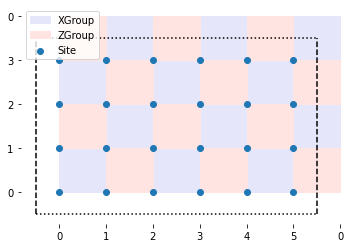

In [5]:
def misc_plot_formatting(fig, ax):
    plt.hlines([-0.5, height-0.5],-0.5, width-0.5, linestyle="dotted", color="black")
    plt.vlines([-0.5, width-0.5], -0.5, height-0.5, linestyle='dashed', color="black")
    plt.xticks(range(width+1), [str(i % width) for i in range(width+1)])
    plt.yticks(range(height+1), [str(i % height) for i in range(height+1)])

    for direction in ['top', 'right', 'bottom', 'left']:
        ax.spines[direction].set_visible(False)
        
    return fig, ax

fig, ax = plt.subplots()
fig, ax = misc_plot_formatting(fig, ax)

for group in xgroup_sites:
    x_patch = ax.add_patch(Polygon(group, color="lavender"))

for group in zgroup_sites:
    z_patch = ax.add_patch(Polygon(group, color="mistyrose"))
    
plt_sites = ax.scatter(*zip(*all_sites))

plt.legend([x_patch, z_patch, plt_sites], ['XGroup', 'ZGroup', 'Site'], loc='upper left')

plt.show()

# Preparing the ground state

A toric ground state is:

$$
| G \rangle =  \prod_{p} \frac{\mathbb{I} + P_p}{\sqrt{2}} |00\dots 0\rangle = \prod_{p} U_p |00\dots 0 \rangle
$$

where $p$ (plaquette) denotes the X Groups.  We won't prove that is the ground state here, we are merely going to use it as is.

Once we know how the operator that applies on a single group, we can tile that decomposition. To better understand this formula, let's write it concretely for a single group of four qubits:

$$
\frac{1}{\sqrt{2}}\left(\mathbb{I} + X_1 X_2 X_3 X_4 \right) |0000 \rangle
= \frac{1}{\sqrt{2}} \left( |0000\rangle + |1111\rangle \right)
$$

This generalized GHZ state can be prepared with a Hadamard and 3 CNOT gates:

Superposition state:  [0.70710678+0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


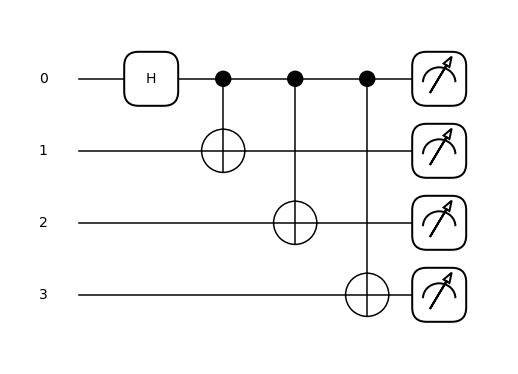

In [6]:
@qml.qnode(qml.device('lightning.qubit', wires=4))
def generalized_ghz():
    qml.Hadamard(0)
    for target in (1,2,3):
        qml.CNOT(wires=(0,target))
    return qml.state()
    
print("Superposition state: ", generalized_ghz())

qml.drawer.use_style('black_white')
fig, ax = qml.draw_mpl(generalized_ghz)()
plt.show()

This decomposition for $U_p$ holds only when the initial Hadamard qubit begins in the $|0\rangle$ state, so we need to be careful in choosing which qubit to apply the initial Hadamard gate to.  This is the reason why we rotated the order for a single X Group on the right border earlier.

We will also not need to prepare the final X Group that contains the four edges of the lattice, as it will already be prepared by preparation of the surrounding groups.

The paper "Realizing topologically ordered states on a quantum processor" that inspired this demo used a special order of operations to prepare the ground state to accomdate the constraints of the Sycamore processor. We don't have the same contraints on a simulator, so we chose a more straightforward ordering.

Now let's actually put these together into a circuit!

In [7]:
dev = qml.device('lightning.qubit', wires= all_sites)

def state_prep():
    for op in xgroup_ops[0:-1]:
        qml.Hadamard(op.wires[0:1])
        for w in op.wires[1:]:
            qml.CNOT(wires=[op.wires[0], w])

@qml.qnode(dev, diff_method=None)
def circuit(observables):
    state_prep()
    return [qml.expval(op) for op in observables]

The value for each group operator that minimizes it's contribution is +1.

All group operators commute (yes, even the different types) so the ground state minimizes all group operators into the +1 state.

$$
S_s |G \rangle = (+1) |G\rangle \qquad P_p | G \rangle = (+1) | G \rangle
$$

In [8]:
xgroup_expvals = circuit(xgroup_ops)
zgroup_expvals = circuit(xgroup_ops)
E0 = -sum(xgroup_expvals) - sum(zgroup_expvals)

print("X Group expectation values", xgroup_expvals)
print("Z Group expectation values", zgroup_expvals)
print("Total energy: ", E0)

X Group expectation values [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Z Group expectation values [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Total energy:  -23.999999999999996


## Excitations

What happens we apply a Pauli operator to the ground state? Let's start by considering what happens to an Z Group eigenvalue when we apply a X operator on one of the sites that it contains:

$$
| \phi \rangle = X_i | G \rangle.
$$

Since the Z Group operator contains a Z operator at the same location as the X operator, the two components anti-commute:

$$
S_s X_i = \left( Z_i Z_a Z_b Z_c \right) X_i = - X_i S_s
$$

Using this relation, we can determine the eigenvalue of the group operator on the pertubed state.

$$
S_s |\phi\rangle = S_s X_i |G\rangle = - X_i S_s |G\rangle = - X_i |G\rangle = - |\phi\rangle
$$

This analysis repeats for the effect of a Z operator on the X Group eigenvalue.

Since each site borders on two X Groups and two Z Groups, applying a single pertubation will flip the signs of two group operators.

Each site with a flipped eigenvalue is considered an excitation. In the literature, you will often see a Z Group excitation $\langle S_s \rangle = -1$ called an "electric" <i>e</i> excitation and an X Group excitation $\langle P_p \rangle = -1$ called a "magnetic" <i>m</i> excitation.  You may also see inclusion of an identity $\mathbb{I}$ particle for the ground state and the combination particle $\Psi$ consisting of a single <i>e</i> and a single <i>m</i> excitation. 

Let's create a QNode where we can apply these pertubations:

In [9]:
@qml.qnode(dev, diff_method=None)
def excitations(observables, x_sites, z_sites):
    state_prep()
    
    for s in x_sites:
        qml.PauliX([s])
        
    for s in z_sites:
        qml.PauliZ([s])

    return [qml.expval(op) for op in observables]

Now what are the expectation values when we apply a single X operation? We see we have indeed flipped the eigenvalues for two groups.

In [10]:
single_x = [(1,2)]

x_expvals = excitations(xgroup_ops, single_x, [])
z_expvals = excitations(zgroup_ops, single_x, [])

print("XGroup: ", x_expvals)
print("ZGroup: ", z_expvals)

XGroup:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ZGroup:  [ 1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


Instead of interpreting the state via the eigenvalues of the operators, we can view the state as occupation numbers of the corresponding quasiparticles. An group with an eigenvalue of $+1$ is in the ground state and thus has an occupation number of $0$.  If the eigenvalue is $-1$, then a quasiparticle exists in that location.

In [11]:
occupation_numbers = lambda expvals: 0.5*(1-expvals)

def print_info(x_expvals, z_expvals):
    E = -sum(x_expvals) - sum(z_expvals)
    
    print("Total energy: ", E)
    print("Energy above the ground state: ", E - E0)
    print("X Group occupation numbers: ", occupation_numbers(x_expvals))
    print("Y Group occupation numbers: ", occupation_numbers(z_expvals))
    
print_info(x_expvals, z_expvals)

Total energy:  -19.999999999999996
Energy above the ground state:  4.0
X Group occupation numbers:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Y Group occupation numbers:  [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Since we are going to plot the same thing many times, we can group the code into a function to easily call later.

In [12]:
def excitation_plot(x_excite, z_excite):
    x_color = lambda expval: "navy" if expval < 0 else "lavender"
    z_color = lambda expval: "maroon" if expval < 0 else "mistyrose"
    
    fig, ax = plt.subplots()
    fig, ax = misc_plot_formatting(fig, ax)
    
    for expval, sites in zip(x_excite, xgroup_sites):
        ax.add_patch(Polygon(sites, color=x_color(expval) ))

    for expval, sites in zip(z_excite, zgroup_sites):
        ax.add_patch(Polygon(sites, color=z_color(expval) ))

    handles = [ Patch(color="navy", label="X Group -1"),
        Patch(color="lavender", label="X Group +1"),
        Patch(color="maroon", label="Z Group -1"),
        Patch(color="mistyrose", label="Z Group +1"),
        Patch(color="navy", label="Z op"),
        Patch(color="maroon", label="X op"),]
    
    plt.legend(handles=handles, ncol=3, loc='lower left')
    
    return fig, ax

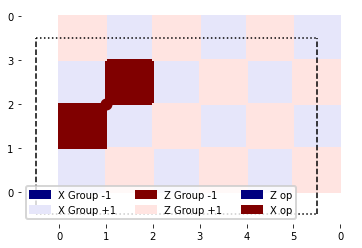

In [13]:
fig, ax = excitation_plot(x_expvals, z_expvals) 

ax.scatter(*zip(*single_x), color="maroon", s=100)

Now what if we apply a Z operation instead at the same site? We instead get two X Group excitations.

Total energy:  -19.999999999999996
Energy above the ground state:  4.0
X Group occupation numbers:  [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Y Group occupation numbers:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


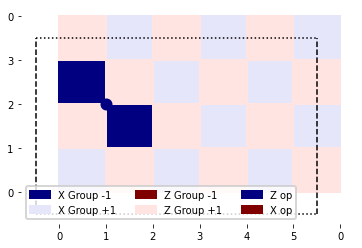

In [14]:
single_z = [(1,2)]

x_expvals = excitations(xgroup_ops, [], single_z)
z_expvals = excitations(zgroup_ops, [], single_z)
print_info(x_expvals, z_expvals)

fig, ax = excitation_plot(x_expvals, z_expvals) 

ax.scatter(*zip(*single_z), color="navy", s=100)

What happens if we apply the same pertubation twice at the same location?

We regain the ground state. The excitations of the toric code are <b>Majorana</b> particles, particles who are their own anti-particles.  While postulated to exist in standard particle physics, majorana particles have only been experimentally seen as quasiparticle excitations in materials.

We can think of the second operation as creating another set of excitations at the same location that annihilate the existing particles.

In [15]:
single_z = [(1,2)]

x_expvals = excitations(xgroup_ops, [], single_z+single_z)
z_expvals = excitations(zgroup_ops, [], single_z+single_z)
print_info(x_expvals, z_expvals)

Total energy:  -23.999999999999996
Energy above the ground state:  0.0
X Group occupation numbers:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Y Group occupation numbers:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Moving Excitations and String Operators

What if we create a second set of particles such that one of the new particles overlaps with an existing particle? Then one old particle and one new particle annihilate each other.  We are left we one of the old particles and one new particle, so we still have two particles in total.

We can think about the situation as creating a new pair of particles where two particles cancel each other out, but we can also view the application of a new pertubation as <b>moving</b> one of the excitations.  Let's see what that looks like in code:

Total energy:  -19.999999999999996
Energy above the ground state:  4.0
X Group occupation numbers:  [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Y Group occupation numbers:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


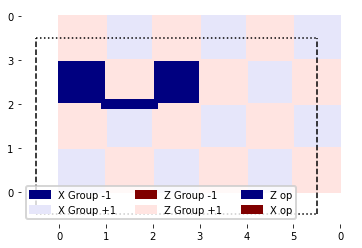

In [16]:
two_z = [(1,2), (2,2)]

x_expvals = excitations(xgroup_ops, [], two_z)
z_expvals = excitations(zgroup_ops, [], two_z)
print_info(x_expvals, z_expvals)

fig, ax = excitation_plot(x_expvals, z_expvals) 

ax.plot(*zip(*two_z), color="navy", linewidth=10)

plt.show()

In that example we just moved an excitation a little.  How about we try moving it even further?

Total energy:  -19.999999999999996
Energy above the ground state:  4.0
X Group occupation numbers:  [0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Y Group occupation numbers:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


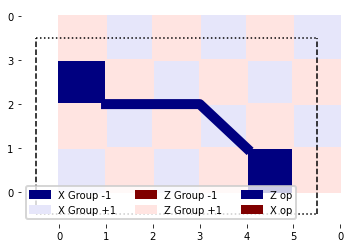

In [17]:
long_string = [(1,2), (2,2), (3,2), (4,1)]

x_expvals = excitations(xgroup_ops, [], long_string)
z_expvals = excitations(zgroup_ops, [], long_string)
print_info(x_expvals, z_expvals)

fig, ax = excitation_plot(x_expvals, z_expvals) 

ax.plot(*zip(*long_string), color="navy", linewidth=10)

plt.show()

We end up with these strings of sites that connect pairs of particles and move them around.

What if we decided to move the particle to it's final location via a different route?

The below string gets us to the exact same final state. The toric code only cares about the <b>homotopy</b> of the path used to create the excitations. As long as the endpoints are the same and the path doesn't wrap around the torus or other particles, the specifics don't matter.

Total energy:  -19.999999999999996
Energy above the ground state:  4.0
X Group occupation numbers:  [0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Y Group occupation numbers:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


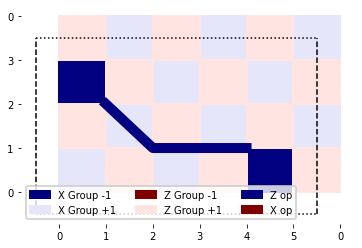

In [18]:
equivalent_string = [(1,2), (2,1), (3,1), (4,1)]

x_expvals = excitations(xgroup_ops, [], equivalent_string)
z_expvals = excitations(zgroup_ops, [], equivalent_string)
print_info(x_expvals, z_expvals)

fig, ax = excitation_plot(x_expvals, z_expvals) 

ax.plot(*zip(*equivalent_string), color="navy", linewidth=10)

plt.show()

# Looping the torus

We can also have a loop of operations that doesn't create any new excitations.  The loop creates a pair, moves one around in a circle, and then annihilates the two particles again.

Total energy:  -23.999999999999996
Energy above the ground state:  0.0
X Group occupation numbers:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Y Group occupation numbers:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


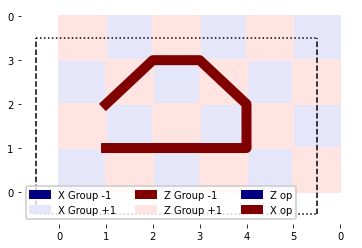

In [19]:
contractable_loop = [(1,1), (2,1), (3,1), (4,1), (4,2), (3,3), (2,3), (1,2)]

x_expvals = excitations(xgroup_ops, contractable_loop, [])
z_expvals = excitations(zgroup_ops, contractable_loop, [])
print_info(x_expvals, z_expvals)

fig, ax = excitation_plot(x_expvals, z_expvals) 

ax.plot(*zip(*contractable_loop), color="maroon", linewidth=10)

The loop doesn't effect the positions of any excitations, but does it effect the state at all?

To answer that question, we will look at the probabilities instead of the expectation values of tensor observables.

In [20]:
@qml.qnode(dev, diff_method=None)
def probs(x_sites, z_sites):
    state_prep()
    
    for s in x_sites:
        qml.PauliX([s])
        
    for s in z_sites:
        qml.PauliZ([s])

    return qml.probs(wires=all_sites)

In [21]:
null_probs = probs([], [])
contractable_probs = probs(contractable_loop, [])

print("Are the probabilities equal? ", np.allclose(null_probs, contractable_probs))

Are the probabilities equal?  True


The toric code only cares about the <b>homotopy</b> of the paths. All paths we can smoothly deform into each other will give the same result.  The "contractable" loop can be smoothly deformed away to nothing, so the state with the contractable loop is the same state as one with no loop.

On the torus, we have three types of unique paths that can't be deformed away to nothing:

* A horizontal loop around the boundaries
* A vertical loop around the boundaries
* A loop around both the horiztonal and vertical boundaries

All of these do not create any net excitations, so the wavefunction remains in the ground state.

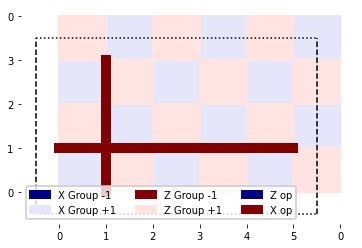

In [22]:
horizontal_loop = [(i, 1) for i in range(width)]
vertical_loop = [(1,i) for i in range(height)]

fig, ax = excitation_plot(excitations(xgroup_ops, horizontal_loop+vertical_loop, []), excitations(zgroup_ops, horizontal_loop, [])) 

ax.plot(*zip(*horizontal_loop), color="maroon", linewidth=10)
ax.plot(*zip(*vertical_loop), color="maroon", linewidth=10)

We can compute the probabilities for each of these four types of loops:

In [23]:
null_probs = probs([], [])
horizontal_probs = probs(horizontal_loop, [])
vertical_probs = probs(vertical_loop, [])
combo_probs = probs(horizontal_loop+vertical_loop, [])

While both X and Z operations can change the group operator eigenvalues and create quasiparticles, only X operators can change the probability distribution.  Applying a Z operator would only rotate the phase of the state and not change any amplitudes. Hence we only use loops of X operators in this section. I encourage you to try this analysis with loops of Z operators to confirm that they do not change the probability distribution.

We can compare the original state and one with a horizontal loop to see if the probability distributions are different:

In [24]:
print("Are the probabilities equal? ",qml.math.allclose(null_probs, horizontal_probs))

Are the probabilities equal?  False


Let's perform an extra sanity check on that to make sure the difference between the probabilties is significant.

In [25]:
print("Maximum difference in probabilities: ", max(abs(null_probs-horizontal_probs)))
print("Maximum probability: ", max(null_probs) )

Maximum difference in probabilities:  0.00048828124999999913
Maximum probability:  0.00048828124999999913


So this isn't just random fluctuations and errors.

That was just comparing a horizontal "x" loop with the initial ground state.  How about the other two types of loops? Let's loop over all combinations of two probability distributions to see if any match.

In [26]:
names = ["null", "x", "y", "combo"]
all_probs = [null_probs, horizontal_probs, vertical_probs, combo_probs]

print("\t"+"\t".join(names))

for name, probs1 in zip(names, all_probs):

    comparisons = (format(np.allclose(probs1, probs2), ".0f") for probs2 in all_probs)
    print(name, "\t", "\t".join(comparisons) )

	null	x	y	combo
null 	 1	0	0	0
x 	 0	1	0	0
y 	 0	0	1	0
combo 	 0	0	0	1


This shows us we have four distinct ground states.  More importantly, these ground states are separated from each other by long-range operations.  We have to perform a loop of operations across the entire lattice in order to switch ground state.

This four way degeneracy is the source of the error correction in the toric code.  Instead 24 qubits, we work with 2 logical qubits (4 states) that are cleanly separated from each other by topological operations.

Further exploration: What happens if you have two loops in the same direction?

## Mutual Exchange Statistics

The hole in the center of the donut isn't the only thing that prevents paths from smoothly deforming into each other. We don't yet know if we can deform paths past other particles.


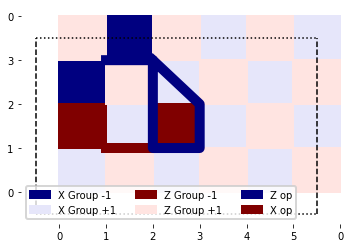

In [27]:
prep1 = [(1, 1), (2,1)]
prep2 = [(1, 3)]
loop1 = [(2,3), (2,2), (2,1), (3,1), (3,2), (2,3)]

x_expvals = excitations(xgroup_ops, prep1, prep2+loop1)
z_expvals = excitations(zgroup_ops, prep1, prep2+loop1)

fig, ax = excitation_plot(x_expvals, z_expvals)

ax.plot(*zip(*prep1), color="maroon", linewidth=10)  
ax.plot(*zip(*(prep2+loop1)), color="navy", linewidth=10)

plt.show()

We can also construct additional strings to prepare two Z Group excitations and move one around the other.  I encourage you to repeat this process for a X Group excitation moving around an X Group excitation, though we will not demonstrate it here.

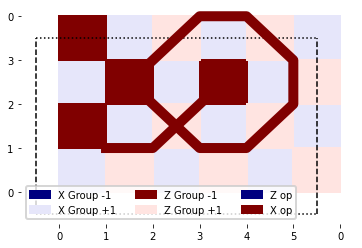

In [28]:
prep3 = [(1,1), (2,1), (3,2)]
prep4 = [(1,3)]

loop2_display = [(2,2), (3,1), (4,1), (5,2), (5,3), (4,4), (3,4), (2,3)]
loop2 = [mod(s) for s in loop2_display]

x_expvals = excitations(xgroup_ops, prep3+prep4+loop2, [])
z_expvals = excitations(zgroup_ops, prep3+prep4+loop2, [])

fig, ax = excitation_plot(x_expvals, z_expvals)

ax.plot(*zip(*prep3), color="maroon", linewidth=10)  
ax.plot(*zip(*prep4), color="maroon", linewidth=10)  
ax.plot(*zip(*loop2_display), color="maroon", linewidth=10)  

plt.show()

## Hadamard test

The Hadamard test extracts the real component of a unitary operation $\text{Re}\left(\langle \psi | U \rangle \right)$. 

1. The auxiliary qubit is prepared into a superposition with a Hadamard gate
2. A controlled version of the operation is performed with the auxiliary qubit as the control
3. Another Hadamard is applied to the auxiliary qubit
4. The auxiliary qubit is measured

<img src="./Hadamard_test.png" />

Since the unitary in this case is the application of a phase to a state, $e^{i \phi}$, the real component is $\cos (\phi)$.

Bonus challenge: Show that the Hadamard tests gives the correct expectation value using pen and paper.

In [33]:
dev_aux = qml.device('lightning.qubit', wires=all_sites + ["aux"])

def loop(x_loop, z_loop):
    for s in x_loop:
        qml.PauliX([s])
    for s in z_loop:
        qml.PauliZ([s])

@qml.qnode(dev_aux, diff_method=None)
def hadamard_test(x_prep, z_prep, x_loop, z_loop):
    state_prep()
    
    for s in x_prep:
        qml.PauliX([s])
        
    for s in z_prep:
        qml.PauliZ([s])
        
    qml.Hadamard("aux")
    qml.ctrl(loop, control="aux")(x_loop, z_loop)
    qml.Hadamard("aux")
    return qml.expval(qml.PauliZ("aux"))

In [35]:
x_around_z = hadamard_test(prep1, prep2, [], loop1)
print("Move x excitation around z excitation: ", x_around_z)

Move x excitation around z excitation:  -0.9999999999999999


We just moved two different types of particles around each other and picked up a phase. As neither bosons nor fermions behave like this, this result demonstrates that the excitations of a toric code are <b>anyons</b>.

We can also check that moving a z group excitation around another does not add a phase:

In [36]:
z_around_z = hadamard_test(prep3+prep4, [], loop2, [])
print("Move z excitation around z excitation: ", z_around_z)

Move z excitation around z excitation:  0.9999999999999999


Further exploration: What is the phase for moving an x excitation around an x excitation? What are the statistics for a combination particle of both an x excitation and z excitation together? The emergent particle should behave like a standard fermion.

In this demo, we have demonstrated:

1. How to prepare the ground state of the toric code model on a lattice of qubits
2. How to create and move excitations
3. The ground state degeneracy of the model on a toric lattice, arising from homotopically distinct loops of operations
4. The excitations are anyons due to non-trivial mutual statistics